$$\textbf{Title generation using Deep Learning}$$

In [1]:
import pandas as pd
import torch
import sklearn
import nltk
import numpy as np
import string

## Imports

In [2]:
import torch.nn as nn

Keras imports to use a tokenizer

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

Linking with google drive to access the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/NLP/data/train.csv')
validation = pd.read_csv('/content/drive/MyDrive/NLP/data/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/NLP/data/test_text.csv')

# $\textbf{Clean and tokenize the data}$

## Clean the data with stopwords removal

In [6]:
!pip install stopwords

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('french'))
    tokens = text.split()
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def preprocess_title(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('french'))
    tokens = text.split()
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

validation_df = validation.copy()
train_df = train.copy()
test_df = test.copy()

# Preprocess the text
validation_df['text'],  validation_df['titles'] = validation_df['text'].apply(preprocess_text), validation_df['titles'].apply(preprocess_title)
train_df['text'],  train_df['titles'] = train_df['text'].apply(preprocess_text), train_df['titles'].apply(preprocess_title)
test_df['text'] = test_df['text'].apply(preprocess_text)

## Construction of the vocabulary

In [9]:
from collections import Counter

words = [word for text in train_df['text'] for word in text.split()]
word_counts = Counter(words)


most_common_words = word_counts.most_common(10000)


vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common_words)}
vocab['<UNK>'] = 0
vocab['<PAD>'] = len(vocab)
vocab["<START>"] = len(vocab)
vocab["<END>"] = len(vocab)


In [10]:
word2idx = vocab
idx2word = {k:v for (v, k)  in word2idx.items()}

## Length visualization

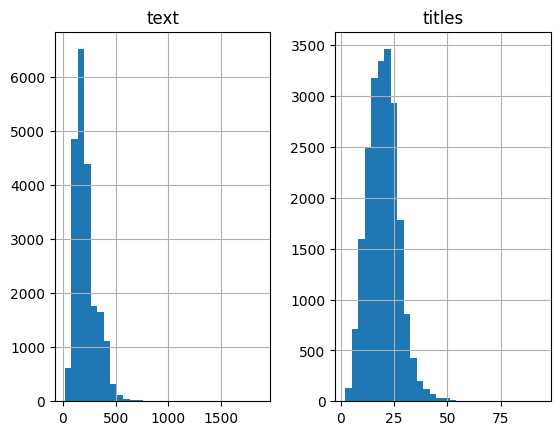

In [ ]:
import matplotlib.pyplot as plt
train_text_word_count = []
train_titles_word_count = []

for i in train_df['text']:
      train_text_word_count.append(len(i.split()))

for i in train_df['titles']:
      train_titles_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':train_text_word_count, 'titles':train_titles_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max_len_text = 300
max_len_titles  = 60

# $\textbf{Model}$

## DataLoader creation

In [11]:
device = torch.device("cuda")
#device = torch.device("cpu")

In [12]:
from torch.utils.data import Dataset, DataLoader

PAD_IDX = word2idx['<PAD>']
vocab_size = len(word2idx)


class TextTitleDataset(Dataset):
    def __init__(self, dataframe, vocab):
        self.dataframe = dataframe
        self.vocab = vocab
        self.start_token = word2idx['<START>']
        self.end_token = word2idx['<END>']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text_tokens = self.tokenize(self.dataframe.iloc[idx]['text'])
        title_tokens = [self.start_token] + self.tokenize(self.dataframe.iloc[idx]['titles']) + [self.end_token]

        return torch.tensor(text_tokens, dtype=torch.long), torch.tensor(title_tokens, dtype=torch.long)

    def tokenize(self, sentence):
        return [self.vocab.get(word, self.vocab['<UNK>']) for word in sentence.split()]



class TestDataset(Dataset):
    def __init__(self, dataframe, vocab):
        self.dataframe = dataframe
        self.vocab = vocab

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.tokenize(self.dataframe.iloc[idx]['text'])
        return torch.tensor(text, dtype=torch.long)

    def tokenize(self, sentence):
        return [self.vocab.get(word, self.vocab['<UNK>']) for word in sentence.split()]

We can now create the properly tokenized datasets.

In [13]:
train_dataset = TextTitleDataset(train_df, word2idx)
validation_dataset = TextTitleDataset(validation_df, word2idx)
test_dataset = TestDataset(test_df, word2idx)

We will now create the different dataloaders

In [14]:
from torch.nn.utils.rnn import pad_sequence

In [15]:
def train_collate_fn(batch):
    texts, titles = zip(*batch)
    texts_pad = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    titles_pad = pad_sequence(titles, batch_first=True, padding_value=PAD_IDX)
    return texts_pad, titles_pad

def test_collate_fn(batch):
    texts = [item for item in batch]
    texts_pad = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    return texts_pad

In [20]:
def create_trainloader(dataset, batch_size = 128):
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn = train_collate_fn)
    return train_loader

def create_testloader(dataset, batch_size = 128):
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn = test_collate_fn)
    return test_loader

In [21]:
train_loader = create_trainloader(train_dataset)
validation_loader = create_trainloader(validation_dataset)
test_loader = create_testloader(test_dataset)

## Layers

### Attention

In [22]:
import torch.nn.functional as F

In [23]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim + dec_hid_dim), dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden.squeeze(0)
        hidden = hidden.unsqueeze(1)
        hidden = hidden.repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)


### Encoder

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn1 = nn.LSTM(emb_dim, enc_hid_dim, batch_first=True)
        self.rnn3 = nn.LSTM(enc_hid_dim, enc_hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        output, (hidden, cell) = self.rnn1(embedded)
        output, (hidden, cell) = self.rnn3(output)
        return output, hidden, cell

### Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim + emb_dim), dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden, encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        weighted = torch.bmm(attn_weights, encoder_outputs)

        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden, cell


### Seq2Seq model

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg):
        encoder_outputs, hidden, cell = self.encoder(src)
        trg_len = trg.shape[1]
        batch_size = trg.shape[0]
        outputs = torch.zeros(batch_size, trg_len, self.decoder.output_dim).to(self.device)

        input = trg[:,0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:,t,:] = output
            input = output.argmax(1)

        return outputs



    def generate_title(self, src, max_len=50, start_token_idx=word2idx['<START>'], end_token_idx=word2idx['<END>'], unk_token_idx=word2idx['<UNK>'], a_token_idx=word2idx['a']):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            encoder_outputs, hidden, cell = self.encoder(src)
            batch_size = src.shape[0]
            outputs = torch.zeros(batch_size, max_len, self.decoder.output_dim).to(self.device)

            input = torch.LongTensor([start_token_idx] * batch_size).to(self.device)

            titles = []
            for t in range(1, max_len):
                output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
                output = output.squeeze(1)
                probs, indices = output.topk(k=3, dim=1)  # Get top 3 predictions
                predicted = indices[:, 0]

                is_unk = predicted == unk_token_idx
                predicted[is_unk] = indices[is_unk, 1]

                is_a_token = predicted == a_token_idx
                predicted[is_a_token] = indices[is_a_token, 2]

                titles.append(predicted.cpu().numpy())
                input = predicted

                if (predicted == end_token_idx).all():
                    break

            titles = np.array(titles).T  # Shape: (batch_size, seq_len)
            return titles


## Creation of the model

In [27]:
input_dim = vocab_size
output_dim = vocab_size
emb_dim = 150 #300
enc_hid_dim = 250 #500
dec_hid_dim = 250 #500

attention_mechanism = Attention(enc_hid_dim, dec_hid_dim)

encoder = Encoder(input_dim, emb_dim, enc_hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim,enc_hid_dim, dec_hid_dim, attention = attention_mechanism).to(device)  # Add attention if needed

In [28]:
model = Seq2Seq(encoder, decoder, device)

In [29]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10004, 150)
    (rnn1): LSTM(150, 250, batch_first=True)
    (rnn3): LSTM(250, 250, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=500, out_features=250, bias=True)
      (v): Linear(in_features=250, out_features=1, bias=False)
    )
    (embedding): Embedding(10004, 150)
    (rnn): LSTM(400, 250, batch_first=True)
    (fc_out): Linear(in_features=650, out_features=10004, bias=True)
  )
)

# Training and validate methods

In [30]:
from torch.cuda.amp import autocast, GradScaler #for an optimized usage of GPU's RAM

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters())


def validate(model, val_loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():

        for texts, titles in val_loader:
            texts, titles = texts.to(device), titles.to(device)
            output = model(texts, titles[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            titles = titles[:, 1:].contiguous().view(-1)
            loss = criterion(output, titles)
            epoch_loss += loss.item()

    return epoch_loss / len(val_loader)


def train(model, dataloader, optimizer, criterion, clip, val_loader):
    model.train()
    epoch_loss = 0
    scaler = GradScaler()

    val_losses_sum = 0

    for texts, titles in dataloader:
        model.train()
        texts, titles = texts.to(device), titles.to(device)

        optimizer.zero_grad()

        with autocast():
            output = model(texts, titles[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            titles = titles[:, 1:].contiguous().view(-1)
            loss = criterion(output, titles)


        scaler.scale(loss).backward()


        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        val_loss = validate(model, val_loader, criterion)

        val_losses_sum += val_loss

    average_epoch_loss = epoch_loss / len(dataloader)
    average_val_loss = val_losses_sum / len(dataloader)

    return average_epoch_loss, average_val_loss


## Training of the model

In [ ]:
num_epochs = 11

clip = 1

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    res = train(model, train_loader, optimizer, criterion, clip, validation_loader)
    train_loss = res[0]
    val_loss = res[1]
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

    save_path = f'/content/drive/MyDrive/NLP/Models/model_epoch{epoch}.pth'
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss' : val_loss}, save_path)

Epoch: 01, Train Loss: 7.354, Val Loss: 7.318
Epoch: 02, Train Loss: 7.158, Val Loss: 7.160
Epoch: 03, Train Loss: 7.065, Val Loss: 7.093
Epoch: 04, Train Loss: 6.971, Val Loss: 7.024
Epoch: 05, Train Loss: 6.850, Val Loss: 6.939
Epoch: 06, Train Loss: 6.728, Val Loss: 6.875
Epoch: 07, Train Loss: 6.618, Val Loss: 6.830


## Plotting of the loss

In [31]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("Loss on training set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.figure()
plt.plot(val_losses)
plt.title("Loss on validation set")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Title generation for the test dataset

In [33]:
def detokenize(indices, idx2word):
    return ' '.join([idx2word.get(idx, '<UNK>') for idx in indices if idx not in (word2idx['<START>'], word2idx['<END>'], word2idx['<PAD>'])])

In [ ]:
generated_titles = []

model.eval()

with torch.no_grad():
    for src_batch in test_loader:
        src_batch = src_batch.to(device)

        for src in src_batch:
            src = src.unsqueeze(0)
            title_idx_seq = model.generate_title(src, max_len=50)[0]

            generated_title = detokenize(title_idx_seq, idx2word)
            generated_titles.append(generated_title)



## Saving the titles

In [ ]:
df = pd.DataFrame({'titles': generated_titles})

In [ ]:
file_path = '/content/drive/MyDrive/NLP/data/generated_titles.csv'
df.to_csv(file_path, index=False)

In [ ]:
gen = pd.read_csv('/content/drive/MyDrive/NLP/data/generated_titles.csv')

# Comparing the models through the epochs

## The initial model, trained on 1 epoch

In [34]:
# Initial model
load_path = '/content/drive/MyDrive/NLP/Models/model_epoch{epoch}.pth'.format(epoch=0)

# Load the saved state
saved_state = torch.load(load_path)

model0 = Seq2Seq(encoder, decoder, device)
optimizer0 = torch.optim.Adam(model0.parameters())

model0.load_state_dict(saved_state['model_state_dict'])
optimizer0.load_state_dict(saved_state['optimizer_state_dict'])


model0.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10004, 150)
    (rnn1): LSTM(150, 250, batch_first=True)
    (rnn3): LSTM(250, 250, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=500, out_features=250, bias=True)
      (v): Linear(in_features=250, out_features=1, bias=False)
    )
    (embedding): Embedding(10004, 150)
    (rnn): LSTM(400, 250, batch_first=True)
    (fc_out): Linear(in_features=650, out_features=10004, bias=True)
  )
)

In [35]:
generated_titles_0 = []

model0.eval()

with torch.no_grad():
    for src_batch in test_loader:
        src_batch = src_batch.to(device)

        for src in src_batch:
            src = src.unsqueeze(0)
            title_idx_seq = model0.generate_title(src, max_len=50)[0]

            generated_title = detokenize(title_idx_seq, idx2word)
            generated_titles_0.append(generated_title)

In [37]:
test['titles'] = generated_titles_0
file_path = '/content/drive/MyDrive/NLP/data/test0.csv'
test.to_csv(file_path)

## The final model

In [38]:
# Final model
load_path = '/content/drive/MyDrive/NLP/Models/model_epoch{epoch}.pth'.format(epoch=6)

# Load the saved state
saved_state = torch.load(load_path)

model10 = Seq2Seq(encoder, decoder, device)
optimizer10 = torch.optim.Adam(model0.parameters())

model10.load_state_dict(saved_state['model_state_dict'])
optimizer10.load_state_dict(saved_state['optimizer_state_dict'])


model10.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10004, 150)
    (rnn1): LSTM(150, 250, batch_first=True)
    (rnn3): LSTM(250, 250, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=500, out_features=250, bias=True)
      (v): Linear(in_features=250, out_features=1, bias=False)
    )
    (embedding): Embedding(10004, 150)
    (rnn): LSTM(400, 250, batch_first=True)
    (fc_out): Linear(in_features=650, out_features=10004, bias=True)
  )
)

In [49]:
generated_titles_0[:10]

['ministre ministre ministre ministre ministre mardi france ministre',
 'ministre ans ministre ans ministre mardi france ministre',
 'ministre ministre ministre ministre mardi france ministre',
 'dun ans plus va plus va plus dun ans plus',
 'ministre ministre ministre ministre ministre mardi france ministre',
 'dun ans trump ans trump ans plus dun ans plus dun coronavirus dun coronavirus dun coronavirus dun',
 'dun ans plus va plus va plus dun ans plus dun dun',
 'ministre ministre ministre ministre mardi france ministre',
 'france ministre ans ministre mardi france ministre depuis france dune',
 'france ans ans plus va plus dun dimanche dun dimanche']

In [39]:
generated_titles_10 = []

model10.eval()

with torch.no_grad():
    for src_batch in test_loader:
        src_batch = src_batch.to(device)

        for src in src_batch:
            src = src.unsqueeze(0)
            title_idx_seq = model10.generate_title(src, max_len=50)[0]

            generated_title = detokenize(title_idx_seq, idx2word)
            generated_titles_10.append(generated_title)

In [48]:
generated_titles_10[:10]

['loi députés nationale mercredi mercredi mercredi mercredi mercredi mercredi',
 'ministre chef ministre mardi mercredi mardi mercredi mardi',
 'informations ans ans ans ans dune après dune',
 'france va plus va plus france va plus france',
 'ministre comptes ministre ministre ministre ministre ministre',
 'étude apple apple plus plus plus plus plus plus plus plus contenus plus plus',
 'dune après violences violences violences paris après contre dune',
 'personnes personnes personnes lundi lundi dimanche dune',
 'france placés france france france france france france',
 'france placés france france france france france france']

In [ ]:
test['titles'] = generated_titles_10
file_path = '/content/drive/MyDrive/NLP/data/test10.csv'
test.to_csv(file_path)